<a href="https://colab.research.google.com/github/Hutaf/SDA-Machine-Learning/blob/daily.activities/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1.2: Dimension reduction and principal component analysis (PCA)

One of the iron laws of data science is know as the "[curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)": as the number of considered features (dimensions) of a space increases, the number of data configurations grows exponentially. Thus the number of observations (data points) needed to account for these configurations must also increase. This fact of life has huge ramifications for the time, computational effort, and memory required. As a result, it is often desirable to reduce the number of dimensions we work with.

The challenge is determining which features we can remove from our analysis.

Not all features are created equal. Certain features may impede our analysis, or simply not be overly important. We need to identify the features to exclude, but obviously we can only take this so far. At a certain point reducing dimensions will also reduce the accuracy of a classifier and our analysis.

## Our scenario

We have a collection of foods and their nutrients. We'd like to group them together so we can see similar items. Our traditional categorization of dairy or vegetables aren't descriptive enouth, and can be a little misleading. For example, not all fruits are created equal - an avocado is rather different from a apple. We'd like to group our foods together based on their composition.

As we begin our analysis, our initial challenge is trying to determine what makes a food item a food item? What components are most important? It's a real struggle to try to determine what components we should focus on.

## PCA in theory

One way to reduce the number of dimensions we have to work with is by projecting (or converting) our feature space into a lower dimensional space. The reason why we can do this is that in most real-world problems, data points are not spread uniformly across all dimensions. Some features might be near constant, while others are highly correlated, which means that those data points lie close to a lower-dimensional subspace.


### An analogy

We can picture the process of PCA reducing the number of dimensions as we would, well, a picture. A picture is a two-dimensional representation of a three-dimensional world. But the reason a pixel sits where it does on a picture and looks how it looks is because of where it is on the X, Y and Z coordinates which make up the world we see. The picture isn't merely taking a two-dimensional slice, but rather consolidating three dimensions into two **new** dimensions.

This is especially evident in a picture with a [bokeh](https://en.wikipedia.org/wiki/Bokeh) effect (those pictures where the subject is in focus and everything else is blurry). The photographer has exerted a fair bit of control over how the conversion from 3-D to 2-D is going to take place. The pixels making up our subject will show as sharp, while all other pixels will be fuzzy. Basically, the photographer is drawing our eyes to what's important.

We can do the same with the dimensions (or columns) in our data, reducing the number and allowing us to focus (pun intended) on the important information.

## PCA in action

PCA behaves much in the same way, by allowing us to focus on what's important, specifically variance. Where are we seeing a spread of data? Where are we seeing change? What's truly impacting the data?

Let's take a look at an example of a three dimensional data space as represented in the image below. The data points are not spread across the entire plane, but are nicely clumped, roughly in an oval. Because the cluster (or, indeed, any cluster) is roughly elliptical, it can be mathematically described by two values: its major (long) axis and its minor (short) axis. These axes form the *principal components* of the cluster. Basically, this is where the magic is happening for our data.

<img align="center" style="padding-right:10px;" src="https://github.com/daniel-dc-cd/data_science/blob/master/daily_materials/ml_kmeans_nb_regression/Images/PCA.png?raw=1">

We can **construct a whole new feature space** around this cluster, defined by two *eigenvectors* (the vectors that define the linear transformation to this new feature space), $c_{1}$ and $c_{2}$. Better still, we don't have to consider all of the dimensions of this new space. Intuitively, we can see that most of the points lie on or close to the line that runs through $c_{1}$. So, if we project the cluster down from two dimensions to that single dimension, we capture most of the information about this data sense while simplifying our analysis. This ability to extract most of the information from a dataset by considering only a fraction of its definitive eigenvectors forms the heart of principal component analysis (PCA).

## Import modules and dataset

You will need to clean and prepare the data in order to conduct PCA on it, so pandas will be essential. You will also need NumPy, a bit of Scikit Learn, and pyplot.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

The dataset we’ll use here is the same one drawn from the [U.S. Department of Agriculture National Nutrient Database for Standard Reference](https://www.ars.usda.gov/northeast-area/beltsville-md-bhnrc/beltsville-human-nutrition-research-center/nutrient-data-laboratory/docs/usda-national-nutrient-database-for-standard-reference/) that you prepared in Section 1.1. Remember to set the encoding to `latin_1` (for those darn µg).

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/daniel-dc-cd/data_science/master/daily_materials/ml_kmeans_nb_regression/Data/USDA-nndb-combined.csv', encoding='latin_1')

We can check the number of columns and rows using the `info()` method for the `DataFrame`.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 54 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NDB_No             8989 non-null   int64  
 1   FoodGroup          8618 non-null   object 
 2   Shrt_Desc          8790 non-null   object 
 3   Water_(g)          8789 non-null   float64
 4   Energ_Kcal         8790 non-null   float64
 5   Protein_(g)        8790 non-null   float64
 6   Lipid_Tot_(g)      8790 non-null   float64
 7   Ash_(g)            8465 non-null   float64
 8   Carbohydrt_(g)     8790 non-null   float64
 9   Fiber_TD_(g)       8196 non-null   float64
 10  Sugar_Tot_(g)      6958 non-null   float64
 11  Calcium_(mg)       8442 non-null   float64
 12  Iron_(mg)          8646 non-null   float64
 13  Magnesium_(mg)     8051 non-null   float64
 14  Phosphorus_(mg)    8211 non-null   float64
 15  Potassium_(mg)     8364 non-null   float64
 16  Sodium_(mg)        8707 

> **Exercise**
>
> Can you think of a more concise way to check the number of rows and columns in a `DataFrame`? (***Hint:*** Use one of the [attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) of the `DataFrame`.)

In [18]:
df.shape

(8989, 54)

In [19]:
#number of rows
len(df)

8989

In [20]:
#number of columns
len(df.columns)

54

## Handle `null` values

Because this is a real-world dataset, it is a safe bet that it has `null` values in it. We could first check to see if this is true. However, later on in this section, we will have to transform our data using a function that cannot use `NaN` values, so we might as well drop rows containing those values.

> **Exercise**
>
> Drop rows from the `DataFrame` that contain `NaN` values. (If you need help remembering which method to use, see [this page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html).)

In [23]:
# Run the code to drop all null and NaN values
df = df.dropna()

Now let’s see how many rows we have left.

In [24]:
df.shape

(2190, 54)

Dropping those rows eliminated 76 percent of our data (8989 entries to 2190). An imperfect state of affairs, but we still have enough for our purposes in this section.

> **Key takeaway:** Another solution to removing `null` values is to impute values for them, but this can be tricky. Should we handle missing values as equal to 0? What about a fatty food with `NaN` for `Lipid_Tot_(g)`? We could try taking the averages of values surrounding a `NaN`, but what about foods that are right next to rows containing foods from radically different food groups? It is possible to make justifiable imputations for missing values, but it can be important to involve subject-matter experts (SMEs) in that process.

## Split off descriptive columns

Our descriptive columns (such as `FoodGroup` and `Shrt_Desc`) pose challenges for us when it comes time to perform PCA because they are categorical rather than numerical features, so we will split our `DataFrame` in to one containing the descriptive information and one containing the nutritional information.

In [25]:
desc_df = df.iloc[:, [0, 1, 2]+[i for i in range(50,54)]]
desc_df.set_index('NDB_No', inplace=True)
desc_df.head()

,FoodGroup,Shrt_Desc,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
NDB_No,,,,,,
1001,Dairy and Egg Products,"BUTTER,WITH SALT","1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1002,Dairy and Egg Products,"BUTTER,WHIPPED,W/ SALT","1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",1 tbsp,205.0,1 cup,0.0
1004,Dairy and Egg Products,"CHEESE,BLUE",1 oz,17.0,1 cubic inch,0.0
1005,Dairy and Egg Products,"CHEESE,BRICK","1 cup, diced",113.0,"1 cup, shredded",0.0


> **Question**
>
> Why was it necessary to structure the `iloc` method call the way we did in the code cell above? What did it accomplish? Why was it necessary set the `desc_df` index to `NDB_No`?

In [26]:
nutr_df = df.iloc[:, :-5] # Remove the last five columns
nutr_df.head()

,NDB_No,FoodGroup,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(Âµg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(Âµg),Folic_Acid_(Âµg),Food_Folate_(Âµg),Folate_DFE_(Âµg),Choline_Tot_ (mg),Vit_B12_(Âµg),Vit_A_IU,Vit_A_RAE,Retinol_(Âµg),Alpha_Carot_(Âµg),Beta_Carot_(Âµg),Beta_Crypt_(Âµg),Lycopene_(Âµg),Lut+Zea_ (Âµg),Vit_E_(mg),Vit_D_Âµg,Vit_D_IU,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg)
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT",15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,2.0,24.0,24.0,643.0,0.09,0.000,0.000,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.17,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,0.0,0.0,7.0,51.368,21.021,3.043,215.0
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,W/ SALT",16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,1.0,24.0,41.0,583.0,0.05,0.010,0.001,0.0,0.0,0.007,0.064,0.022,0.097,0.008,4.0,0.0,4.0,4.0,18.8,0.07,2468.0,683.0,671.0,1.0,135.0,6.0,0.0,13.0,1.37,0.0,0.0,4.6,45.390,19.874,3.331,225.0
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,0.0,3.0,5.0,2.0,0.01,0.001,0.000,0.0,0.0,0.001,0.005,0.003,0.010,0.001,0.0,0.0,0.0,0.0,22.3,0.01,3069.0,840.0,824.0,0.0,193.0,0.0,0.0,0.0,2.80,0.0,0.0,8.6,61.924,28.732,3.694,256.0
3,1004,Dairy and Egg Products,"CHEESE,BLUE",42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,23.0,387.0,256.0,1146.0,2.66,0.040,0.009,14.5,0.0,0.029,0.382,1.016,1.729,0.166,36.0,0.0,36.0,36.0,15.4,1.22,721.0,198.0,192.0,0.0,74.0,0.0,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0
4,1005,Dairy and Egg Products,"CHEESE,BRICK",41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,24.0,451.0,136.0,560.0,2.60,0.024,0.012,14.5,0.0,0.014,0.351,0.118,0.288,0.065,20.0,0.0,20.0,20.0,15.4,1.26,1080.0,292.0,286.0,0.0,76.0,0.0,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0


> **Question**
>
> What did the `iloc` syntax do in the code cell above?

In [27]:
nutr_df = nutr_df.drop(['FoodGroup', 'Shrt_Desc'], axis=1)

> **Exercise**
>
> Now set the index of `nutr_df` to use `NDB_No`.

In [28]:
nutr_df.set_index('NDB_No')

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(Âµg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(Âµg),Folic_Acid_(Âµg),Food_Folate_(Âµg),Folate_DFE_(Âµg),Choline_Tot_ (mg),Vit_B12_(Âµg),Vit_A_IU,Vit_A_RAE,Retinol_(Âµg),Alpha_Carot_(Âµg),Beta_Carot_(Âµg),Beta_Crypt_(Âµg),Lycopene_(Âµg),Lut+Zea_ (Âµg),Vit_E_(mg),Vit_D_Âµg,Vit_D_IU,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg)
NDB_No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,2.0,24.0,24.0,643.0,0.09,0.000,0.000,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.17,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,0.0,0.0,7.0,51.368,21.021,3.043,215.0
1002,16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,1.0,24.0,41.0,583.0,0.05,0.010,0.001,0.0,0.0,0.007,0.064,0.022,0.097,0.008,4.0,0.0,4.0,4.0,18.8,0.07,2468.0,683.0,671.0,1.0,135.0,6.0,0.0,13.0,1.37,0.0,0.0,4.6,45.390,19.874,3.331,225.0
1003,0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,0.0,3.0,5.0,2.0,0.01,0.001,0.000,0.0,0.0,0.001,0.005,0.003,0.010,0.001,0.0,0.0,0.0,0.0,22.3,0.01,3069.0,840.0,824.0,0.0,193.0,0.0,0.0,0.0,2.80,0.0,0.0,8.6,61.924,28.732,3.694,256.0
1004,42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,23.0,387.0,256.0,1146.0,2.66,0.040,0.009,14.5,0.0,0.029,0.382,1.016,1.729,0.166,36.0,0.0,36.0,36.0,15.4,1.22,721.0,198.0,192.0,0.0,74.0,0.0,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0
1005,41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,24.0,451.0,136.0,560.0,2.60,0.024,0.012,14.5,0.0,0.014,0.351,0.118,0.288,0.065,20.0,0.0,20.0,20.0,15.4,1.26,1080.0,292.0,286.0,0.0,76.0,0.0,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44061,4.20,356.0,5.30,2.40,9.90,78.20,6.1,0.70,126.0,3.11,89.0,1660.0,1279.0,2838.0,0.41,0.838,0.703,3.9,0.0,0.020,0.090,0.400,0.055,0.040,6.0,0.0,6.0,6.0,3.3,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.02,0.0,0.0,0.4,0.984,1.154,0.131,0.0
44158,54.66,181.0,0.41,0.20,0.35,44.38,2.6,37.75,27.0,0.80,10.0,12.0,115.0,12.0,0.10,0.112,0.215,0.4,0.7,0.023,0.034,0.091,0.092,0.029,1.0,0.0,1.0,1.0,3.8,0.00,22.0,1.0,0.0,0.0,13.0,0.0,0.0,33.0,0.23,0.0,0.0,3.9,0.000,0.000,0.000,0.0
44203,28.24,287.0,0.08,0.01,0.07,71.60,0.0,24.53,2.0,0.04,1.0,2.0,23.0,0.0,0.02,0.020,0.045,0.5,4.2,0.009,0.017,0.026,0.023,0.005,5.0,0.0,5.0,5.0,3.0,0.00,12.0,1.0,0.0,0.0,2.0,9.0,0.0,12.0,0.02,0.0,0.0,0.0,0.003,0.001,0.009,0.0


> **Exercise solution**
>
> The correct code for students to use here is `nutr_df.set_index('NDB_No', inplace=True)`.

Now let’s take a look at `nutr_df`.

In [29]:
nutr_df.head()

,NDB_No,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(Âµg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(Âµg),Folic_Acid_(Âµg),Food_Folate_(Âµg),Folate_DFE_(Âµg),Choline_Tot_ (mg),Vit_B12_(Âµg),Vit_A_IU,Vit_A_RAE,Retinol_(Âµg),Alpha_Carot_(Âµg),Beta_Carot_(Âµg),Beta_Crypt_(Âµg),Lycopene_(Âµg),Lut+Zea_ (Âµg),Vit_E_(mg),Vit_D_Âµg,Vit_D_IU,Vit_K_(Âµg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg)
0,1001,15.87,717.0,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,2.0,24.0,24.0,643.0,0.09,0.000,0.000,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.17,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,0.0,0.0,7.0,51.368,21.021,3.043,215.0
1,1002,16.72,718.0,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,1.0,24.0,41.0,583.0,0.05,0.010,0.001,0.0,0.0,0.007,0.064,0.022,0.097,0.008,4.0,0.0,4.0,4.0,18.8,0.07,2468.0,683.0,671.0,1.0,135.0,6.0,0.0,13.0,1.37,0.0,0.0,4.6,45.390,19.874,3.331,225.0
2,1003,0.24,876.0,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,0.0,3.0,5.0,2.0,0.01,0.001,0.000,0.0,0.0,0.001,0.005,0.003,0.010,0.001,0.0,0.0,0.0,0.0,22.3,0.01,3069.0,840.0,824.0,0.0,193.0,0.0,0.0,0.0,2.80,0.0,0.0,8.6,61.924,28.732,3.694,256.0
3,1004,42.41,353.0,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,23.0,387.0,256.0,1146.0,2.66,0.040,0.009,14.5,0.0,0.029,0.382,1.016,1.729,0.166,36.0,0.0,36.0,36.0,15.4,1.22,721.0,198.0,192.0,0.0,74.0,0.0,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0
4,1005,41.11,371.0,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,24.0,451.0,136.0,560.0,2.60,0.024,0.012,14.5,0.0,0.014,0.351,0.118,0.288,0.065,20.0,0.0,20.0,20.0,15.4,1.26,1080.0,292.0,286.0,0.0,76.0,0.0,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0


## Normalize and center the data

Our numeric data comes in a variety of mass units (grams, milligrams, and micrograms) and one energy unit (kilocalories). In order to make an apples-to-apples comparison (pun intended) of the nutritional data, we need to first *normalize* the data and make it more normally distributed (that is, make the distribution of the data look more like a familiar bell curve). PCA needs relatively normalized data to perform its magic.

To help see why we need to normalize the data, let's look at a histogram of all of the columns.

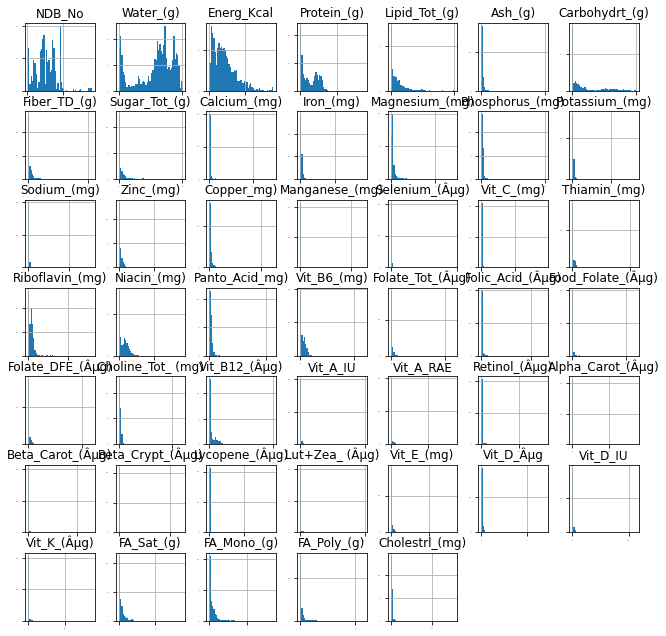

In [30]:
ax = nutr_df.hist(bins=50, xlabelsize=-1, ylabelsize=-1, figsize=(11,11))

### Our first transformation - Box-Cox

Not a bell curve in sight. Worse, a lot of the data is clumped at or around 0. There are a number of ways we can massage the data into a a more useable state.

We're going to start by trying the [Box-Cox Transformation](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/) on the data, a popular transformation. It does require a strictly positive input, so we will add 1 to every value in each column.

In [31]:
nutr_df = nutr_df + 1

Now for the transformation. The Box-Cox Transformation performs the transformation $y(\lambda) = \dfrac{y^{\lambda}-1}{\lambda}$ for $\lambda \neq 0$ and $y(\lambda) = log y$ for $\lambda = 0$ for all values $y$ in a given column. SciPy has a particularly useful `boxcox()` function that can automatically calculate the $\lambda$ for each column that best normalizes the data in that column. (However, it is does not support `NaN` values; scikit-learn has a comparable `boxcox()` function that is `NaN`-safe, but it is not available on the version of scikit-learn that comes with Azure notebooks.)

In [32]:
from scipy.stats import boxcox

nutr_df_TF = pd.DataFrame(index=nutr_df.index)
for col in nutr_df.columns.values:
    nutr_df_TF['{}_TF'.format(col)] = boxcox(nutr_df.loc[:, col])[0]

Let's now take a look at the `DataFrame` containing the transformed data.

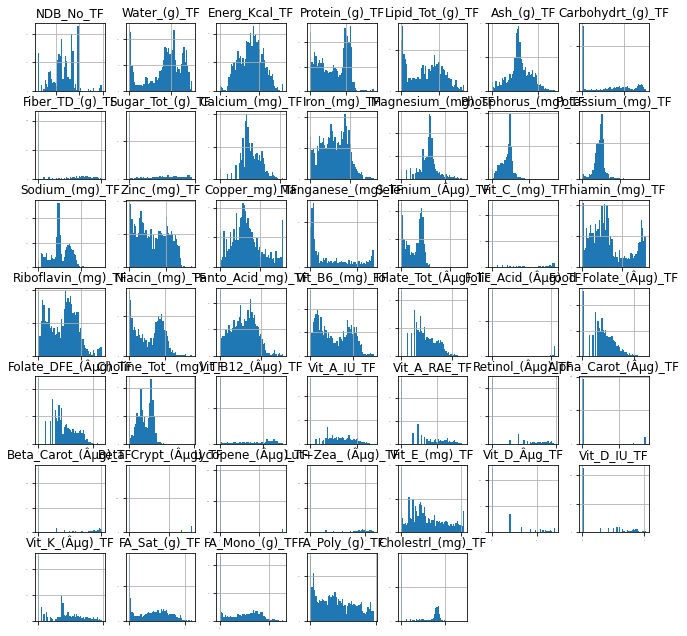

In [33]:
ax = nutr_df_TF.hist(bins=50, xlabelsize=-1, ylabelsize=-1, figsize=(11,11))

A few of the columns now look about right, but unfortunately we really didn't see the results we were hoping for, which was bell curves for the bulk of our columns.

### Standard scaling

Our data units were incompatible to begin with, and the transformations haven't given us any real improvement. We can apply a different technique - centering the data around 0; that is, we will again transform the data, this time so that every column has a mean of 0 and a standard deviation of 1. Put another way, we're going to standardize our data around 0. Scikit-learn has a convenient function for this - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). We're going to call `fit_transform` to perform the conversion. Please note `fit_transform` will return a `numpy` array rather than a `DataFrame`.

In [34]:
nutr_df_TF = StandardScaler().fit_transform(nutr_df_TF)

You can satisfy your self that the data is now centered by using the `mean()` method on the array.

In [35]:
print("mean: ", np.round(nutr_df_TF.mean(), 2))

mean:  -0.0


> **Exercise**
>
> Find the standard deviation for the `nutr_df_TF`. (If you need a hint, you can always use **tab** in Jupyter notebooks)

In [38]:
nutr_df_TF.std()

1.0

## PCA in practice

It is finally time to perform the PCA on our data. (As stated before, even with pretty clean data, a lot of effort has to go into preparing the data for analysis.)

In [39]:
fit = PCA()
pca = fit.fit_transform(nutr_df_TF)

So, now that we have peformed the PCA on our data, what do we actually have? Remember that PCA is foremost about finding the eigenvectors for our data. We then want to select some subset of those vectors to form the lower-dimensional subspace in which to analyze our data.

Let's take a look at a scatter plot created by the first two components. We can already see some clustering, which we'll be able to better represent when we get towards the end.

Text(0.5, 1.0, 'Collapsed data')

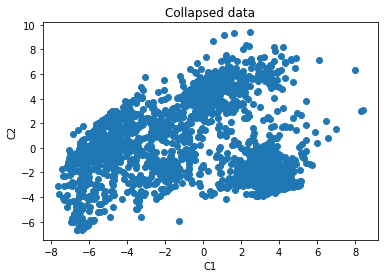

In [57]:
plt.scatter(pca[:,0], pca[:,1])
plt.xlabel('C1')
plt.ylabel('C2')
plt.title('Collapsed data')

Not all of the eigenvectors are created equal. Just a few of them will account for the majority of the variance in the data. (Put another way, a subspace composed of just a few of the eigenvectors will retain the majority of the information from our data.) We want to focus on those vectors.

To help us get a sense of how many vectors we should use, consider this scree graph of the variance for the PCA components, which plots the variance explained by the components from greatest to least.

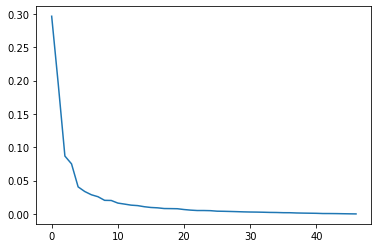

In [42]:
plt.plot(fit.explained_variance_ratio_)

This is where data science can become an art. As a rule of thumb, we want to look for "elbow" in the graph, which is the point at which the few components have captured the majority of the variance in the data (after that point, we are only adding complexity to the analysis for increasingly diminishing returns). In this particular case, that appears to be at about five components.

We can take the cumulative sum of the first five components to see how much variance they capture in total.

In [43]:
print(fit.explained_variance_ratio_[:5].sum())

0.6928086119508389


So our five components capture about 70 percent of the variance. We can see what fewer or additional components would yield by looking at the cumulative variance for all of the components. You can see increasing to 6 components would cover an additional 3 percentage points over the first 5, and there's an ever-diminisioning return.

In [44]:
fit.explained_variance_ratio_.cumsum()

array([0.29632648, 0.49049329, 0.57724476, 0.65228399, 0.69280861,
       0.72640656, 0.7551366 , 0.78092388, 0.8012938 , 0.82145872,
       0.8377138 , 0.85246179, 0.865621  , 0.87807887, 0.88887634,
       0.89853107, 0.9076723 , 0.91575025, 0.92371178, 0.93149755,
       0.93807822, 0.94376877, 0.94887553, 0.95397086, 0.958854  ,
       0.96296784, 0.96691119, 0.97059707, 0.97400153, 0.9770842 ,
       0.97994791, 0.98268824, 0.98520875, 0.98746622, 0.98960433,
       0.99145147, 0.99324725, 0.99467345, 0.99589785, 0.99697336,
       0.99789323, 0.99848818, 0.99905637, 0.99953424, 0.99983525,
       0.99998804, 1.        ])

We can also examine this visually.

Text(0.5, 1.0, 'Cumulative Explained Variance Graph')

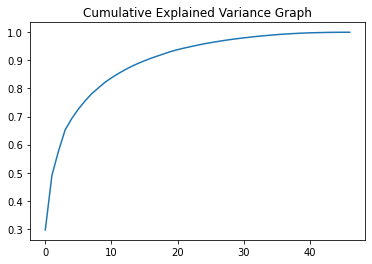

In [45]:
plt.plot(np.cumsum(fit.explained_variance_ratio_))
plt.title("Cumulative Explained Variance Graph")

Ultimately, it is a matter of judgment as to how many components to use, but five vectors (and 70 percent of the variance) will suffice for our purposes in this section.

To aid further analysis, let's now put those five components into a DataFrame.

In [46]:
pca_df = pd.DataFrame(pca[:, :5], index=desc_df.index)
pca_df.head()

,0,1,2,3,4
NDB_No,,,,,
1001,-0.732037,-1.707279,4.026262,6.099510,-1.274695
1002,-1.735579,-0.738615,5.142564,5.936871,-2.264282
1003,-2.247710,-3.886305,3.300821,7.230059,-3.397515
1004,3.585201,0.259868,4.311568,1.008528,1.941350
1005,2.695601,-0.331593,4.389608,1.925306,1.828534


Each column represents one of the eigenvectors, and each row is one of the coordinates that defines that vector in five-dimensional space.

We will want to add the FoodGroup column back in to aid with our interpretation of the data later on. Let's also rename the component-columns $c_{1}$ through $c_{5}$ so that we know what we are looking at.

In [47]:
pca_df = pca_df.join(desc_df)
pca_df.drop(['FoodGroup', 'GmWt_Desc1', 'GmWt_2', 'GmWt_Desc2', 'Refuse_Pct', 'Shrt_Desc'], axis=1, inplace=True)
pca_df.rename(columns={0:'c1', 1:'c2', 2:'c3', 3:'c4', 4:'c5'}, inplace=True)

Don't worry that the FoodGroup column has all `NaN` values: it is not a vector, so it has no vector coordinates.

One last thing we should demonstrate is that each of the components is mutually perpendicular (or orthogonal in math-speak). One way of expressing that condition is that each component-vector should perfectly correspond with itself and not correlate at all (positively or negatively) with any other vector.

In [48]:
np.round(pca_df.corr(), 5)

,c1,c2,c3,c4,c5
c1,1.0,0.0,0.0,-0.0,0.0
c2,0.0,1.0,0.0,-0.0,-0.0
c3,0.0,0.0,1.0,-0.0,0.0
c4,-0.0,-0.0,-0.0,1.0,0.0
c5,0.0,-0.0,0.0,0.0,1.0


## Interpreting the results

What do our new vectors mean? What is driving our data? To see these results, we will create pandas Series for each of the components, index them by feature, and then sort them in descreasing order (so that a higher number represents a feature that is positively correlated with that vector and negative numbers represent low correlation).

In [49]:
vects = fit.components_[:5]

In [50]:
c1 = pd.Series(vects[0], index=nutr_df.columns)
c1.sort_values(ascending=False)

Protein_(g)          0.249612
Selenium_(Âµg)       0.234515
Zinc_(mg)            0.228939
Choline_Tot_ (mg)    0.224752
Phosphorus_(mg)      0.217308
Niacin_(mg)          0.208345
Cholestrl_(mg)       0.205733
Panto_Acid_mg)       0.201055
Riboflavin_(mg)      0.201028
Vit_B12_(Âµg)        0.199544
FA_Mono_(g)          0.194594
Lipid_Tot_(g)        0.191798
Vit_B6_(mg)          0.191526
FA_Sat_(g)           0.188748
Vit_D_IU             0.173971
FA_Poly_(g)          0.154780
Iron_(mg)            0.152441
Energ_Kcal           0.150843
Vit_D_Âµg            0.146460
Ash_(g)              0.137944
Potassium_(mg)       0.134949
Magnesium_(mg)       0.133265
Thiamin_(mg)         0.131898
Retinol_(Âµg)        0.118535
Sodium_(mg)          0.099912
Copper_mg)           0.084969
Calcium_(mg)         0.051026
Vit_E_(mg)           0.034175
NDB_No               0.030397
Food_Folate_(Âµg)    0.008557
Folate_Tot_(Âµg)     0.007171
Folate_DFE_(Âµg)     0.006639
Folic_Acid_(Âµg)    -0.002939
Vit_A_RAE 

Our first component is primarily driven by the amounts of protein, selenium and zinc, while the amounts of vitamin C and sugar have a lessened impact.

In [51]:
c2 = pd.Series(vects[1], index=nutr_df.columns)
c2.sort_values(ascending=False)

Manganese_(mg)       0.280677
Folate_DFE_(Âµg)     0.271974
Folate_Tot_(Âµg)     0.271423
Fiber_TD_(g)         0.270580
Food_Folate_(Âµg)    0.241602
Carbohydrt_(g)       0.232894
Copper_mg)           0.218687
Magnesium_(mg)       0.210462
Calcium_(mg)         0.189096
Iron_(mg)            0.179731
Ash_(g)              0.176376
Lut+Zea_ (Âµg)       0.175818
Vit_K_(Âµg)          0.168465
Vit_E_(mg)           0.167723
Sugar_Tot_(g)        0.159880
Folic_Acid_(Âµg)     0.156876
Thiamin_(mg)         0.146673
Energ_Kcal           0.133983
Potassium_(mg)       0.126495
Beta_Carot_(Âµg)     0.124504
FA_Poly_(g)          0.123916
Phosphorus_(mg)      0.091412
Vit_C_(mg)           0.086557
Sodium_(mg)          0.082325
Riboflavin_(mg)      0.082285
Alpha_Carot_(Âµg)    0.076695
Beta_Crypt_(Âµg)     0.062937
Lipid_Tot_(g)        0.056329
NDB_No               0.054100
Vit_A_IU             0.054025
Panto_Acid_mg)       0.045132
Lycopene_(Âµg)       0.045007
FA_Mono_(g)          0.033104
Vit_A_RAE 

Our second component is primarily driven by the amounts of fiber, manganese and folate.

By using PCA we've been able to distill our data down into fewer, more meaningful dimensions and gain insights we might miss otherwise.

## Using our PCA results for categorization

One of the most common uses of PCA is to prepare data for categorization. PCA provides meaningful dimensions which are non-correlated, so our cluster will typically provide better results. This is why we started with PCA to before we attempted to cluster our foods together.

To perform the categorization, we're going to use [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering). In a nutshell, k-means will look to identify groups (or clusters) in our data.

We're going to start by loading the library, creating our model, and then fitting our PCA results into the model. We are arbitrarily using 3 clusters; in [Machine Learning 2](https://github.com/microsoft/Reactors/tree/main/Machine_Learning_2) there is a deeper conversation of k-means and how to determine the best number of clusters. We're using just the first 5 components as we determined it will provide the best return on investment.

In [52]:
from sklearn.cluster import KMeans
kmeansmodel = KMeans(n_clusters=3, random_state=13)
kmeansmodel.fit(pca[:, :5])
kmeansmodel.labels_

array([1, 1, 1, ..., 1, 2, 1], dtype=int32)

Let's recreate our `DataFrame` with the PCA values, a new column named **Cluster** which will hold the `label_` or cluster number for each food item, and add back in the text descriptions.

In [53]:
# Create a new data frame
pca_df = pd.DataFrame(pca[:, :5], index=desc_df.index)

# Add in the cluster number
pca_df['Cluster'] = kmeansmodel.labels_

# Add in the text descriptions
pca_df = pca_df.join(desc_df)
pca_df.head()

,0,1,2,3,4,Cluster,FoodGroup,Shrt_Desc,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
NDB_No,,,,,,,,,,,,
1001,-0.732037,-1.707279,4.026262,6.099510,-1.274695,1,Dairy and Egg Products,"BUTTER,WITH SALT","1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1002,-1.735579,-0.738615,5.142564,5.936871,-2.264282,1,Dairy and Egg Products,"BUTTER,WHIPPED,W/ SALT","1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
1003,-2.247710,-3.886305,3.300821,7.230059,-3.397515,1,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS",1 tbsp,205.0,1 cup,0.0
1004,3.585201,0.259868,4.311568,1.008528,1.941350,0,Dairy and Egg Products,"CHEESE,BLUE",1 oz,17.0,1 cubic inch,0.0
1005,2.695601,-0.331593,4.389608,1.925306,1.828534,0,Dairy and Egg Products,"CHEESE,BRICK","1 cup, diced",113.0,"1 cup, shredded",0.0


### Exploring our clusters

Let's see the products which wound up in the first cluster.

In [56]:
pca_df.loc[pca_df['Cluster'] == 0]['Shrt_Desc'][:500]

NDB_No
1004                                           CHEESE,BLUE
1005                                          CHEESE,BRICK
1006                                           CHEESE,BRIE
1007                                      CHEESE,CAMEMBERT
1009                                        CHEESE,CHEDDAR
                               ...                        
13818    BEEF,CHUCK,BLADE RST,LN&FAT,1/8"FAT,CHOIC,CKD,...
13821    BEEF,CHK EYE RST,BNL,AMERICA'S BF RST,LN,0" FA...
13822    BEEF,CHK EYE RST,BNLESS,AMERICA'S BF RST,LN,0"...
13823    BEEF,CHUCK EYE RST,BNLESS,AMERICA'S BF RST,LN,...
13829    BEEF,RIB,WHL (RIBS 6-12),LN&FAT,1/8"FAT,CHOIC,...
Name: Shrt_Desc, Length: 500, dtype: object

> **Exercise** Display the first 500 rows for the remaining two clusters

In [54]:
# Display cluster two (remember indexing starts at 0)
pca_df.loc[pca_df['Cluster'] == 1]['Shrt_Desc'][:500]

NDB_No
1001                                      BUTTER,WITH SALT
1002                                BUTTER,WHIPPED,W/ SALT
1003                                  BUTTER OIL,ANHYDROUS
1012                   CHEESE,COTTAGE,CRMD,LRG OR SML CURD
1013                           CHEESE,COTTAGE,CRMD,W/FRUIT
                               ...                        
11715         LIMA BNS,IMMAT SEEDS,CND,NO SALT,SOL&LIQUIDS
11716    LIMA BNS,IMMAT SEEDS,FRZ,BABY,CKD,BLD,DRND,W/SALT
11727                BEANS,SNAP,YEL,CND,REG PK,SOL&LIQUIDS
11728               BEANS,SNAP,YEL,CND,NO SALT,SOL&LIQUIDS
11729                  BEANS,SNAP,GRN,CND,NO SALT,DRND SOL
Name: Shrt_Desc, Length: 500, dtype: object

In [55]:
# Display cluster three (remember indexing starts at 0)
pca_df.loc[pca_df['Cluster'] == 2]['Shrt_Desc'][:500]

NDB_No
1091       MILK,DRY,NONFAT,REG,WO/ ADDED VIT A & VITAMIN D
1113                                       WHEY,ACID,DRIED
1135         EGG,WHITE,DRIED,FLAKES,STABILIZED,GLUCOSE RED
1136            EGG,WHITE,DRIED,PDR,STABILIZED,GLUCOSE RED
1144                                 EGG SUBSTITUTE,POWDER
                               ...                        
42178                            MAYONNAISE,MADE WITH TOFU
42196     CANDIES,MARS SNACKFOOD US,MILKY WAY MIDNIGHT BAR
42227    CANDIES,MARS SNACKFOOD US,M&M'S ALMOND CHOC CA...
43441                                   ROLLS,PUMPERNICKEL
43528                     BEVERAGES,ABBOTT,ENSURE PLUS,RTD
Name: Shrt_Desc, Length: 500, dtype: object

### Conclusion

Reducing dimensions to allow us to focus on what's important can be a bit of a a challenge. And, frankly, PCA can be a bit confusing at first. PCA's main goal is to provide us with a better signal to noise ratio. It helps us weed out the dimensions which aren't as important, and provide more meaningful insights into the relationships between our data. It's commonly used before categorization algorithms, such as k-means.